In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark

--2023-02-19 18:30:16--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-19 18:30:16 ERROR 404: Not Found.


gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import json
import glob
import os
import time
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

import seaborn as sns
import copy

import warnings
warnings.simplefilter(action='ignore')

In [3]:
import findspark
import random
import pyspark
from pyspark.sql import functions as f
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression
from scipy.stats import spearmanr

In [58]:
# initiaiting spark context
findspark.init()
sc = pyspark.SparkContext("local", appName="MillionSongsPredictions")

In [59]:
# open data directly from file
spark = SparkSession(sc)
full_data = spark.read.option("escape","\"").csv("/content/drive/MyDrive/bdp/final project/cleaned_data.csv", header=True, sep=',', multiLine=True)

In [60]:
full_data = full_data.withColumn('hit', when(full_data['song_hotttnesss'] >=0.5,1).otherwise(0))

In [61]:
full_data.show(5)

+---+------------------+-------------------+--------------------+---------------+----------------+------------------+-------------------+----------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------+---+--------------+--------+----+---------------+-----------------+-------+--------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------------+------------+---+
|_c0|artist_familiarity|  artist_hotttnesss|           artist_id|artist_latitude|artist_longitude|   artist_location|        artist_name|         release|    song_hotttnesss|               title|        artist_terms

# Visualize Data

In [62]:
import pandas as pd
col_names = 'artist_id','song_hotttnesss' ,'artist_location', 'duration', 'loudness' , 'year','tempo','artist_hotttnesss','artist_familiarity'
dfp = pd.DataFrame(columns=col_names)
dfp['song_hotttnesss'] = full_data.select('song_hotttnesss').toPandas().astype(float)
dfp['artist_hotttnesss'] = full_data.select('artist_hotttnesss').toPandas().astype(float)
dfp['artist_familiarity'] = full_data.select('artist_familiarity').toPandas().astype(float)
dfp['duration'] = full_data.select('duration').toPandas().astype(float)
dfp['loudness'] = full_data.select('loudness').toPandas().astype(float)
dfp['tempo'] = full_data.select('tempo').toPandas().astype(float)
dfp['year'] = full_data.select('year').toPandas().astype(float)
dfp['artist_id'] = full_data.select('artist_id').toPandas()
dfp['artist_location'] = full_data.select('artist_location').toPandas()

In [20]:
dfcor = dfp[['song_hotttnesss' , 'duration', 'loudness' , 'tempo','artist_hotttnesss']]
corr = dfcor.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,song_hotttnesss,duration,loudness,tempo,artist_hotttnesss
song_hotttnesss,1.000000,0.044236,0.259075,0.082776,0.555970
duration,0.044236,1.000000,0.080676,-0.005405,0.029883
loudness,0.259075,0.080676,1.000000,0.171553,0.244266
tempo,0.082776,-0.005405,0.171553,1.000000,0.053064
artist_hotttnesss,0.555970,0.029883,0.244266,0.053064,1.000000


In [21]:
dfp.head()

,artist_id,song_hotttnesss,artist_location,duration,loudness,year,tempo,artist_hotttnesss,artist_familiarity
0,b'ARD7TVE1187B99BFB1',0.602120,b'California - LA',218.93180,-11.197,0.0,92.198,0.401998,0.581794
1,b'ARXR32B1187FB57099',0.604501,b'',209.60608,-4.501,2007.0,129.738,0.401724,0.651046
2,b'AR8ZCNI1187B9A069B',0.265861,b'',269.81833,-13.496,1984.0,86.643,0.332276,0.426668
3,b'ARGSJW91187B9B1D6B',0.000000,b'North Carolina',218.77505,-10.021,0.0,146.765,0.296269,0.360031
4,b'ARC43071187B990240',0.265861,"b'Wisner, LA'",245.21098,-7.545,0.0,117.975,0.351556,0.545159


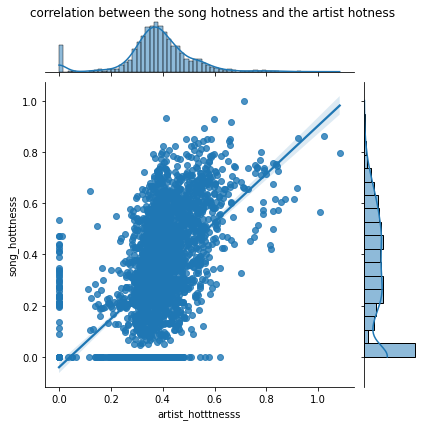

SpearmanrResult(correlation=0.5812179786570961, pvalue=3.652486686754483e-250)

In [22]:
hottness = dfp[['artist_id','artist_hotttnesss','song_hotttnesss']]
hottness.set_index("artist_id",inplace=True)
hottness= hottness.groupby('artist_id').mean()

p = sns.jointplot(data=hottness,x='artist_hotttnesss', y='song_hotttnesss',kind='reg')
p.fig.suptitle("correlation between the song hotness and the artist hotness")
p.fig.subplots_adjust(top=0.95)
plt.show()

spearmanr(hottness['artist_hotttnesss'],hottness['song_hotttnesss'])

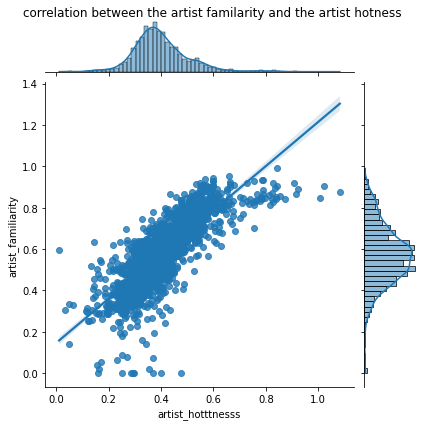

SpearmanrResult(correlation=0.8252212588906779, pvalue=0.0)

In [23]:
artist = dfp[['artist_id','artist_hotttnesss','artist_familiarity']]
artist.set_index("artist_id",inplace=True)
artist= artist.groupby('artist_id').mean()
artist = artist[artist['artist_hotttnesss']>0]

p = sns.jointplot(data=artist,x='artist_hotttnesss', y='artist_familiarity',kind='reg')
p.fig.suptitle("correlation between the artist familarity and the artist hotness")
p.fig.subplots_adjust(top=0.95)
plt.show()

spearmanr(artist['artist_hotttnesss'],artist['artist_familiarity'])

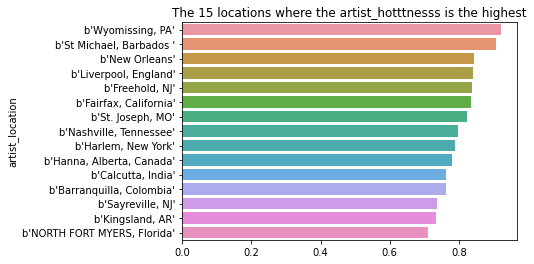

In [24]:
location= dfp[['artist_location','artist_hotttnesss']].groupby('artist_location').mean()
biggest = location['artist_hotttnesss'].nlargest(n=15)

sns.barplot(x = biggest.values,y = biggest.index).set_title("The 15 locations where the artist_hotttnesss is the highest")
plt.show()

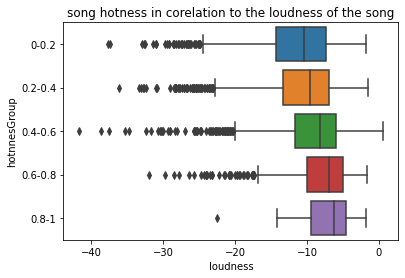

In [25]:
loud = dfp.copy()
bins= [0,0.2,0.4,0.6,0.8,1]
labels = ['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']
loud['hotnnesGroup'] = pd.cut(loud['song_hotttnesss'], bins=bins,labels=labels, right=False)

sns.boxplot(data=loud, x="loudness", y="hotnnesGroup").set_title(
  "song hotness in corelation to the loudness of the song")
plt.show()

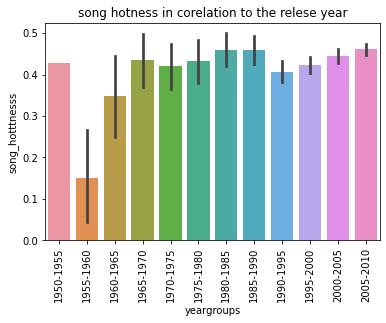

In [28]:
year = dfp[dfp['year']>0].copy()
bins= [1950]
lables = []
last = 1950
for i in range(0,12):
  last = last+5
  bins.append(last)
  lables.append(f'{last-5}-{last}')

year['yeargroups'] = pd.cut(year['year'], bins=bins,labels=lables, right=False)

sns.barplot(data = year,x='yeargroups',y = 'song_hotttnesss').set_title(
  "song hotness in corelation to the relese year")
plt.xticks(rotation = 90)
plt.show()

# Splitting in training and test set

In [63]:
training_columns = ['artist_familiarity', 'artist_idIndex', 'artist_hotttnesss', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'year']

In [64]:
full_data = full_data.withColumn("duration",f.col("duration").cast("float"))
full_data = full_data.withColumn("end_of_fade_in",f.col("end_of_fade_in").cast("float"))
full_data = full_data.withColumn("key",f.col("key").cast("int"))
full_data = full_data.withColumn("key_confidence",f.col("key_confidence").cast("float"))
full_data = full_data.withColumn("loudness",f.col("loudness").cast("float"))
full_data = full_data.withColumn("mode",f.col("mode").cast("float"))
full_data = full_data.withColumn("start_of_fade_out",f.col("start_of_fade_out").cast("float"))
full_data = full_data.withColumn("tempo",f.col("tempo").cast("float"))
full_data = full_data.withColumn("artist_hotttnesss",f.col("artist_hotttnesss").cast("float"))
full_data = full_data.withColumn("time_signature",f.col("time_signature").cast("float"))
full_data = full_data.withColumn("time_signature_confidence",f.col("time_signature_confidence").cast("float"))
full_data = full_data.withColumn("year",f.col("year").cast("float"))
full_data = full_data.withColumn("artist_idIndex",f.col("artist_idIndex").cast("float"))
full_data = full_data.withColumn("artist_familiarity",f.col("artist_familiarity").cast("float"))

In [65]:
dat_assembler = VectorAssembler(inputCols=training_columns, outputCol='features', handleInvalid="keep")

In [66]:
ready_data = dat_assembler.transform(full_data).select('features','hit')

In [67]:
train_data, val_data = ready_data.randomSplit([0.67, 0.33])

# Using a **Random Forests** to make predictions

In [74]:
rfc = RandomForestClassifier(labelCol='hit', featuresCol='features',numTrees=20,maxDepth=10)
rfc_model = rfc.fit(train_data)


In [75]:
rfc_preds = rfc_model.transform(val_data)

In [76]:
rfc_preds.show(5)

+--------------------+---+--------------------+--------------------+----------+
|            features|hit|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[0.0,1975.0,0.370...|  1|[16.4600665749984...|[0.82300332874992...|       0.0|
|[0.0,2128.0,0.0,2...|  0|[19.7521087752225...|[0.98760543876112...|       0.0|
|[0.01555788051337...|  0|[19.3942721473069...|[0.96971360736534...|       0.0|
|[0.03461732342839...|  0|[19.7574681078911...|[0.98787340539455...|       0.0|
|[0.04284826666116...|  0|[16.3064411542570...|[0.81532205771285...|       0.0|
+--------------------+---+--------------------+--------------------+----------+
only showing top 5 rows



In [77]:
auc = BinaryClassificationEvaluator(labelCol='hit')

In [78]:
print('AUC:', auc.evaluate(rfc_preds))

AUC: 0.8330266175382127


In [79]:
evaluator = MulticlassClassificationEvaluator(labelCol="hit", predictionCol="prediction",metricName="accuracy")
tpr = MulticlassClassificationEvaluator(labelCol="hit", predictionCol="prediction",metricName="truePositiveRateByLabel")
fpr = MulticlassClassificationEvaluator(labelCol="hit", predictionCol="prediction",metricName="falsePositiveRateByLabel")

In [80]:
acc_rf = evaluator.evaluate(rfc_preds) 
TPR_rf = tpr.evaluate(rfc_preds) 
FPR_rf = fpr.evaluate(rfc_preds) 
print('Accuracy:', acc_rf)

Accuracy: 0.7935828877005348


# Using a **Logistic Regression** to make predictions

In [85]:
lr = LogisticRegression(labelCol="hit", featuresCol="features",maxIter=5)
lr_model = lr.fit(train_data)

In [86]:
lr_preds = lr_model.transform(val_data)

In [87]:
lr_preds.show(5)

+--------------------+---+--------------------+--------------------+----------+
|            features|hit|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[0.0,1975.0,0.370...|  1|[4.79684164128140...|[0.99181181919210...|       0.0|
|[0.0,2128.0,0.0,2...|  0|[6.67093036465749...|[0.99873438458576...|       0.0|
|[0.01555788051337...|  0|[4.94738612436078...|[0.99294813369158...|       0.0|
|[0.03461732342839...|  0|[6.07221435935307...|[0.99769924457789...|       0.0|
|[0.04284826666116...|  0|[3.72702190456965...|[0.97650109172370...|       0.0|
+--------------------+---+--------------------+--------------------+----------+
only showing top 5 rows



In [88]:
print('AUC:', auc.evaluate(lr_preds))

AUC: 0.8388926413824982


In [89]:
acc_lr = evaluator.evaluate(lr_preds) 
TPR_lr = tpr.evaluate(lr_preds) 
FPR_lr = fpr.evaluate(lr_preds) 
print('Accuracy:', acc_lr)

Accuracy: 0.788235294117647


# Using a **Decision Tree** to make predictions

In [81]:
dt = DecisionTreeClassifier(labelCol="hit", featuresCol="features", maxDepth=20,maxBins=50)

In [82]:
dt_model = dt.fit(train_data)
dt_preds = dt_model.transform(val_data)

In [83]:
print('AUC:', auc.evaluate(dt_preds))

AUC: 0.6885675226396704


In [84]:
acc_dt = evaluator.evaluate(dt_preds) 
TPR_dt = tpr.evaluate(dt_preds) 
FPR_dt = fpr.evaluate(dt_preds) 
print('Accuracy:', acc_dt)

Accuracy: 0.7160427807486631


# EVALUATION

In [101]:
# Calculate AUC
def plot_and_calc_roc(model,preds,name):
  """This function calculates TPR, FPR, AUC and plots the ROC curve"""
  plt.figure(figsize=(8, 6))
  plt.title(f'ROC {name}', fontsize=18)
  plt.xlabel('FPR', fontsize=16)
  plt.ylabel('TPR', fontsize=16)
  plt.xlim([-0.01, 1.00])
  plt.ylim([-0.01, 1.01])
  plt.plot(model.summary.roc.select('FPR').collect(),
          model.summary.roc.select('TPR').collect(), lw=3,
          label=f"{name}(area = {round(auc.evaluate(preds),2)})")
  plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
  plt.legend(loc='lower right', fontsize=14)
  plt.show()

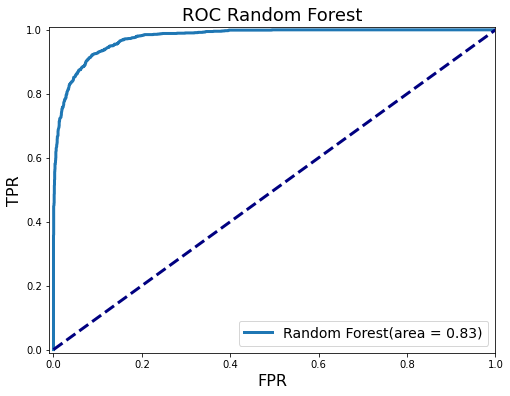

In [102]:
plot_and_calc_roc(rfc_model,rfc_preds,'Random Forest')

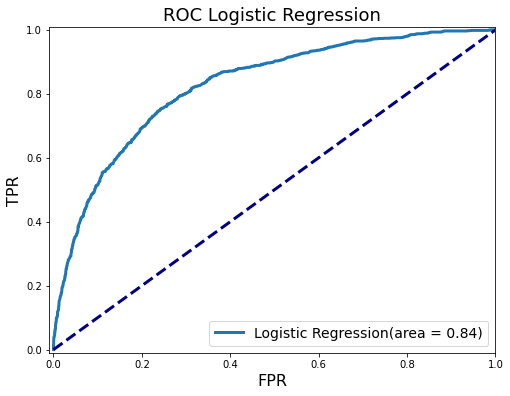

In [103]:
plot_and_calc_roc(lr_model,lr_preds,'Logistic Regression')

In [104]:
result = pd.DataFrame({
            'Random Forest':[acc_rf, TPR_rf, FPR_rf],
#             'XGB':[acc_xgb, TPR_xgb, FPR_xgb],
            'Logistic Regression':[acc_lr, TPR_lr, FPR_lr],
#             'KNN':[acc_knn, TPR_knn, FPR_knn],
            'Decision Tree Classifier':[acc_dt, TPR_dt, FPR_dt],
            },
            index=['Accuracy','TPR','FPR']).transpose()

result = result.sort_values(['Accuracy', 'TPR', 'FPR'], 
                    ascending = [False, False, True])

result

,Accuracy,TPR,FPR
Random Forest,0.793583,0.901463,0.451839
Logistic Regression,0.788235,0.914550,0.499124
Decision Tree Classifier,0.716043,0.792148,0.457093


In [105]:
sc.stop()